In [14]:
import sys
sys.path.append('..')

import os

from spp import process
from spp import market
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [22]:
ticker = "CMCSA"
rsi_pipe = process.RsiBinPipeline(ticker, period="1y", window_size=15)
rsi_pipe

RsiBinPipeline(_cut_stage, _rsicol_stage, _lnprof_stage, _window_stage, _target_stage, _binarize_stage, _drop_stage, _target_stage, _drop_stage, _drop_stage, _traintest_stage, _pop_stage, _pop_stage, _targetsseparate_stage)

In [23]:
X_train, y_train, X_test, y_test = rsi_pipe.get_data()

[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_list[i]["RSI"] = _rsi(dataframe)


## Logistic Regression

C:\Users\valer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\valer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Model earned 112200.75$ out of 124668.04$ starting from 100000$ 
Train accuracy 0.59 
Test accuracy  0.57


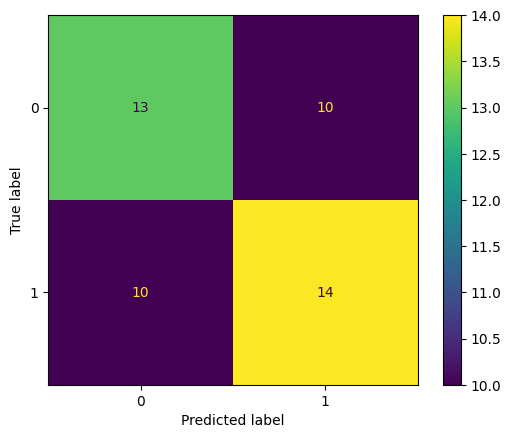

In [24]:
model = LogisticRegression().fit(X_train, y_train)
y_train_pred_bin = model.predict(X_train)
y_test_pred_bin = model.predict(X_test)

df = rsi_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
                                               # ! proposed bin not price

start_capital = 100000
tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
traded_capital = tt.trade()
maximal_caital = bt.trade()
print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {model.score(X_train, y_train):.2f} \nTest accuracy  {model.score(X_test, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)

In [25]:
tickers = ["EBAY", "ALGN", "CMCSA"]
byt = market.BinYearTest(tickers, process.RsiBinPipeline, end_date=None, window_size=15)

In [26]:
orig_stdout = sys.stdout
orig_stderr = sys.stderr
f = open(os.devnull, 'w')
sys.stdout = f
sys.stderr = f
year_test_df = byt.trade(model)
sys.stdout = orig_stdout
sys.stderr = orig_stderr

In [27]:
pd.options.display.float_format = '{:,.2f}'.format
year_test_df

,Month,TrainAcc,TestAcc,Income,Potential
0,May_2022,0.64,0.33,1.01,0.11
1,Jun_2022,0.60,0.60,1.04,0.34
2,Jul_2022,0.59,0.54,1.04,0.26
3,Aug_2022,0.60,0.51,0.96,-0.57
4,Sep_2022,0.61,0.50,0.95,-0.45
5,Oct_2022,0.62,0.49,1.03,0.30
6,Nov_2022,0.60,0.50,1.00,-0.03
7,Dec_2022,0.59,0.57,1.04,0.32
8,Jan_2023,0.59,0.57,1.04,0.48
9,Feb_2023,0.60,0.49,1.00,0.01


In [28]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)

Year capital multiplier 1.1399519343515614
